# Imports

In [1]:
from torchmetrics.classification import MulticlassF1Score
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from scipy import interp
from itertools import cycle

from torch.optim.lr_scheduler import ExponentialLR

from sklearn import metrics
import seaborn as sns


c:\Users\Joaoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\Joaoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Read kapton data

In [2]:
df = pd.read_csv('kapton_data.csv', sep = ';')

In [3]:
print(df.columns)

Index(['Time', 'N1', 'P1', 'P2', 'N3', 'P3', 'AP', 'N1_prev1', 'P1_prev1',
       'P2_prev1', 'N3_prev1', 'P3_prev1', 'N1_prev2', 'P1_prev2', 'P2_prev2',
       'N3_prev2', 'P3_prev2', 'N1_prev3', 'P1_prev3', 'P2_prev3', 'N3_prev3',
       'P3_prev3'],
      dtype='object')


# Split data, create weights

In [4]:
# Read data
data = df
X = data.drop(columns = ['Time', 'AP']) 
for c in X.columns:
    X[c] = X[c] / X[c].abs().max()
y = data['AP']

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [7]:
class_counts = torch.bincount(y)
data_size = len(y)

class_weights = data_size / (len(class_counts) * class_counts)
class_weights

tensor([0.1623, 2.4129, 3.4938, 2.2212, 2.1500, 2.1779, 2.3131, 2.1922, 2.1922,
        2.3957])

# Training Function

In [36]:
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val, train_again = False, lr = 0.0001, lr_step = False, class_weights = class_weights):
    # loss function and optimizer
    loss_fn = nn.CrossEntropyLoss(weight = class_weights)  
    optimizer = optim.Adam(model.parameters(), lr= lr)
    
    if lr_step:
        lr_scheduler = ExponentialLR(optimizer, gamma = 0.99)

    if train_again:
        n_epochs = 1000 # number of epochs to run
        batch_size = 5  # size of each batch
    else:
        n_epochs = 500   
        batch_size = 10  
        
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable= True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                _, predicted = torch.max(y_pred, 1)
                F1 = (predicted == y_batch).float().mean()

                # lr_scheduler.step()
                
                bar.set_postfix(
                    loss=float(loss),
                    F1=float(F1)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        f1 = MulticlassF1Score(num_classes= 10) # calculates statistics for each label and computes weighted average using their support
        acc = f1(y_pred, y_val) * 100 
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/1000; F1 Score: {acc}; Loss: {loss}")
            
        if lr_step:
            lr_scheduler.step()
    # restore model with best weights and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

# Models

In [18]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(20, 60)
        self.layer2 = nn.Linear(60, 60)
        self.layer3 = nn.Linear(60, 60)
        self.layer4 = nn.Linear(60, 60)
        
        self.act = nn.ReLU()
        self.output = nn.Linear(60, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.act(self.layer3(x))
        x = self.act(self.layer4(x))
        x = self.logsoftmax(self.output(x))
        return x
    
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(len(data.columns[1:-1]), 64)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(64, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.logsoftmax(self.output(x))
        return x
    
    
class Decreasing(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(20, 80)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(80, 40)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(40, 20)
        self.act3 = nn.ReLU()

        
        self.output = nn.Linear(20, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.logsoftmax(self.output(x))
        return x
    


class Wider(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(len(data.columns[1:-1]), 184)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(184, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.logsoftmax(self.output(x))
        return x

# Deep Kapton Model

In [9]:
# Compare model sizes
model = Deep()
print("Model size:", sum([x.reshape(-1).shape[0] for x in model.parameters()]))

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)

cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test]) # Only train/test with a small sample of the data
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc, deep_std))

# rebuild model with full set of training data
print("Retrain a deep model")
model_deep = Deep()
acc = model_train(model_deep, X_train, y_train, X_test, y_test, train_again = True)

print(f"Final model accuracy: {acc:.2f}%")

Model size: 12850
Accuracy (deep): 90.94
Accuracy (deep): 90.48
Accuracy (deep): 91.72
Accuracy (deep): 90.25
Accuracy (deep): 91.56
Deep: 90.99% (+/- 0.58%)
Retrain a deep model
Final model accuracy: 92.80%


## CM

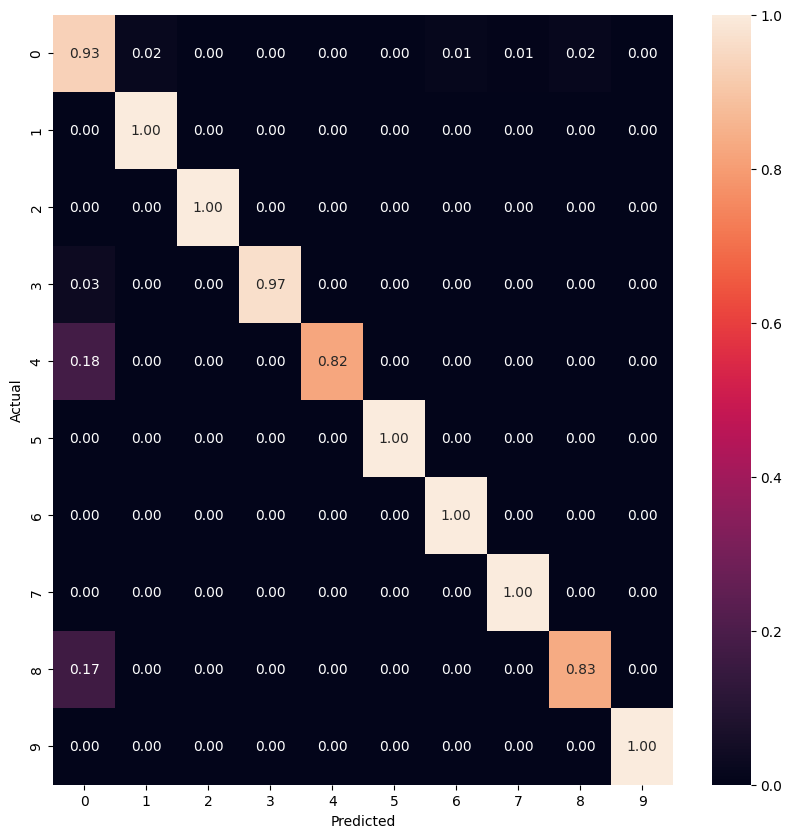

In [10]:
y_pred = model_deep(X_test)
_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_test.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Save

In [12]:
torch.save(model_deep, f'93F1_4layerDeep.pth')

# Wide Model

In [13]:
# Compare model sizes
model = Wide()
print("Model size:", sum([x.reshape(-1).shape[0] for x in model.parameters()])) 


cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model2 = Wide()
    acc = model_train(model2, X_train[train], y_train[train], X_train[test], y_train[test]) # Only train/test with a small sample of the data
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_deep)
wide_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc, wide_std))

# rebuild model with full set of training data
print("Retrain a wide model")
model_wide = Wide()
acc = model_train(model_wide, X_train, y_train, X_test, y_test, train_again = True)

print(f"Final model accuracy: {acc:.2f}%")

Model size: 1994
Accuracy (wide): 80.95
Accuracy (wide): 80.08
Accuracy (wide): 80.16
Accuracy (wide): 82.25
Accuracy (wide): 80.98
Wide: 80.88% (+/- 0.78%)
Retrain a wide model
Final model accuracy: 87.71%


## CM

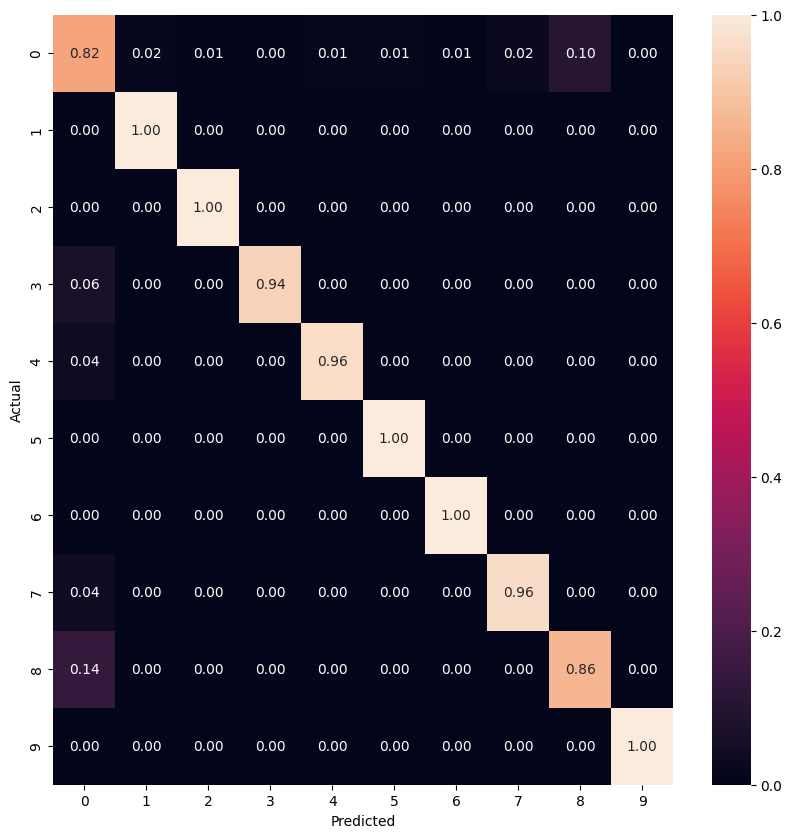

In [15]:
y_pred = model_wide(X_test)
_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_test.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Decreasing Model

In [18]:
# Compare model sizes
model = Decreasing()
print("Model size:", sum([x.reshape(-1).shape[0] for x in model.parameters()]))  # 11041

cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model3 = Decreasing()
    acc = model_train(model3, X_train[train], y_train[train], X_train[test], y_train[test]) # Only train/test with a small sample of the data
    print("Accuracy (decreasing): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
dec_acc = np.mean(cv_scores_deep)
dec_std = np.std(cv_scores_deep)
print("Decreasing: %.2f%% (+/- %.2f%%)" % (dec_acc, dec_std))

# rebuild model with full set of training data
print("Retrain a decreasing model")
model_decreasing = Decreasing()
acc = model_train(model_decreasing, X_train, y_train, X_test, y_test, train_again = True)

print(f"Final model accuracy: {acc:.2f}%")

Model size: 5950
Accuracy (decreasing): 87.13
Accuracy (decreasing): 86.94
Accuracy (decreasing): 87.13
Accuracy (decreasing): 87.20
Accuracy (decreasing): 89.10
Decreasing: 87.50% (+/- 0.80%)
Retrain a decreasing model
Final model accuracy: 92.54%


## CM

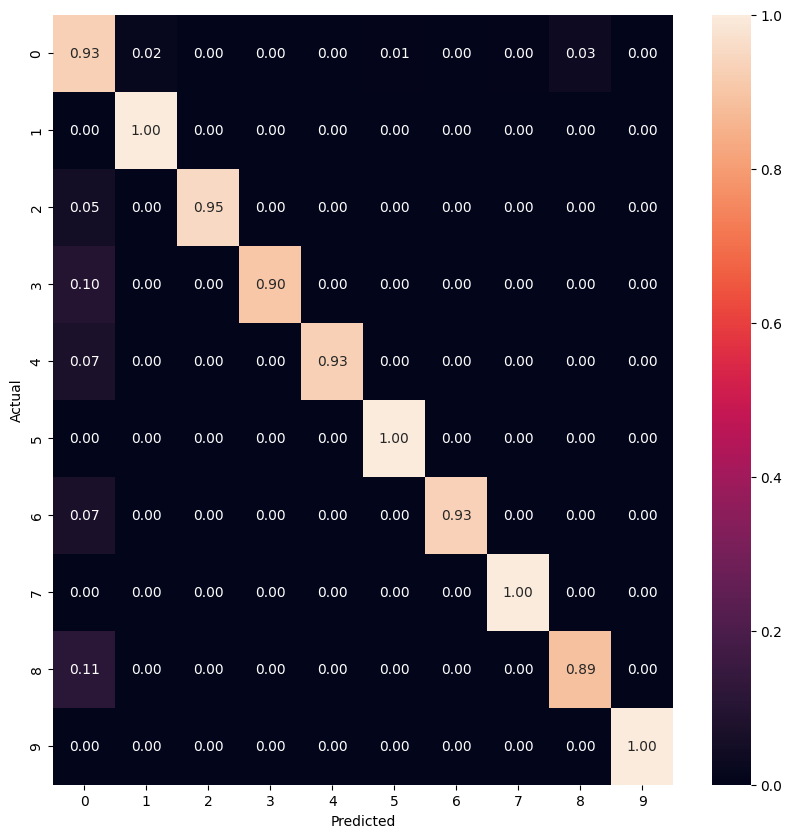

In [19]:
y_pred = model_decreasing(X_test)
_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_test.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Wider Model

In [ ]:
# Compare model sizes
model = Wider()
print("Model size:", sum([x.reshape(-1).shape[0] for x in model.parameters()]))  # 11041


cv_scores_wider = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model4 = Decreasing()
    acc = model_train(model4, X_train[train], y_train[train], X_train[test], y_train[test]) # Only train/test with a small sample of the data
    print("Accuracy (wider): %.2f" % acc)
    cv_scores_wider.append(acc)

# evaluate the model
wider_acc = np.mean(cv_scores_wider)
wider_std = np.std(cv_scores_wider)
print("Wider: %.2f%% (+/- %.2f%%)" % (wider_acc, wider_std))

# rebuild model with full set of training data
print("Retrain a wider model")
model_wider = Wider()
acc = model_train(model_wider, X_train, y_train, X_test, y_test, train_again = True)

print(f"Final model accuracy: {acc:.2f}%")

Model size: 5714
Accuracy (decreasing): 79.33
Accuracy (decreasing): 69.69
Accuracy (decreasing): 75.27
Accuracy (decreasing): 71.57
Accuracy (decreasing): 80.77
Decreasing: 75.33% (+/- 4.28%)
Retrain a decreasing model
Final model accuracy: 90.44%


In [ ]:
y_pred = model_wider(X_test)
_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_test.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Test TP data

In [8]:
TP_df = pd.read_csv('5datasets_13&14&17Jul.csv', sep = ';')

In [99]:
# Read data
data = TP_df
X_TP = data.drop(columns = ['AP']) 
X_norm = df.drop(columns = ['AP'])
for c in X_TP.columns:
    X_TP[c] = X_TP[c] / X_norm[c].abs().max()
y_TP = data['AP']

encoder = LabelEncoder()
encoder.fit(y_TP)
y_TP = encoder.transform(y_TP)

# Convert to 2D PyTorch tensors
X_TP = torch.tensor(X_TP.values, dtype=torch.float32)
y_TP = torch.tensor(y_TP, dtype=torch.long)

# train-test split: Hold out the test set for final model evaluation
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

F1 scores: 13%


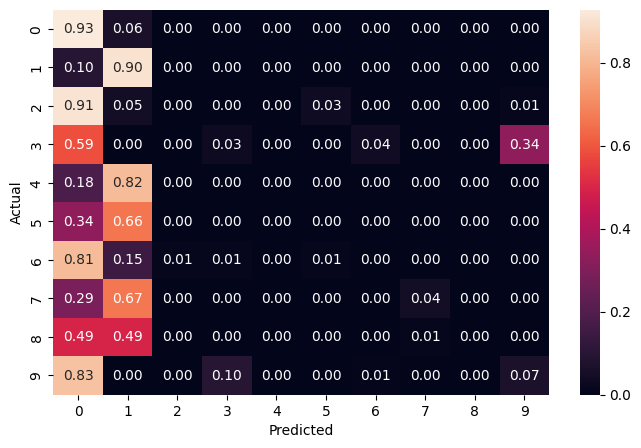

In [81]:
y_pred = model_deep(X_TP)

f1 = MulticlassF1Score(num_classes= 10)
print(f"F1 scores: {f1(y_pred, y_TP).item() * 100:.0f}%")

_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_TP.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.show()

# Train deep model with entire data

In [80]:
# Read data
df = pd.read_csv('kapton_data.csv', sep = ';')
normed_df = df.drop(columns = ['Time']).copy()
normed_TP_df = TP_df.copy()

for c in df.drop(columns = ['Time', 'AP']).columns:
    normed_df[c] = df[c] / df[c].abs().max()
    normed_TP_df[c] = TP_df[c] / TP_df[c].abs().max()
    
data = pd.concat((normed_df, normed_TP_df)).reset_index(drop = True)

y_all = data['AP']
X_all = data.drop(columns = ['AP'])

encoder = LabelEncoder()
encoder.fit(y_all)
y_all = encoder.transform(y_all)

# Convert to 2D PyTorch tensors
X_all = torch.tensor(X_all.values, dtype=torch.float32)
y_all = torch.tensor(y_all, dtype=torch.long)

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, shuffle=True)

In [81]:
data.shape

(5082, 21)

In [129]:
class_counts = torch.bincount(y_all)
total_count = class_counts.sum()

class_weights = total_count / (len(class_counts) * class_counts)
class_weights

tensor([0.1706, 2.2892, 2.7620, 2.0914, 2.0492, 2.0659, 2.2000, 2.0914, 2.1000,
        2.0828])

In [130]:
KTPM = Deep()

acc = model_train(KTPM, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 12.31874942779541; Loss: 2.118401527404785
Epoch 100/1000; F1 Score: 77.40922546386719; Loss: 0.2812923789024353
Epoch 200/1000; F1 Score: 83.75003051757812; Loss: 0.11269073188304901
Epoch 300/1000; F1 Score: 86.70186614990234; Loss: 0.018754273653030396
Epoch 400/1000; F1 Score: 86.8871841430664; Loss: 0.009846697561442852
Epoch 500/1000; F1 Score: 87.28119659423828; Loss: 0.004707902669906616
Epoch 600/1000; F1 Score: 86.71066284179688; Loss: 0.0033263834193348885
Epoch 700/1000; F1 Score: 86.76187896728516; Loss: 0.0018760666716843843
Epoch 800/1000; F1 Score: 86.61216735839844; Loss: 0.0012039277935400605
Epoch 900/1000; F1 Score: 86.99629211425781; Loss: 0.001050883554853499
Achieved F1 Score: 88.18%


In [87]:
KTPM1 = Deep()

acc = model_train(KTPM1, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1e-3)
print(f"Achieved F1 Score: {acc:.2f}%")
torch.save(KTPM1, f'{round(acc)}_KTPM1.pth')

Epoch 0/1000; F1 Score: 40.44055938720703; Loss: 1.135710597038269
Epoch 100/1000; F1 Score: 87.11428833007812; Loss: 0.0028973359148949385
Epoch 200/1000; F1 Score: 88.47045135498047; Loss: 0.0005985628231428564
Epoch 300/1000; F1 Score: 86.27957153320312; Loss: 6.538207526318729e-05
Epoch 400/1000; F1 Score: 88.26893615722656; Loss: 0.005151380319148302
Epoch 500/1000; F1 Score: 88.65840911865234; Loss: 1.9511075151967816e-05
Epoch 600/1000; F1 Score: 88.69176483154297; Loss: 4.1549824914000055e-07
Epoch 700/1000; F1 Score: 87.69083404541016; Loss: 0.06415298581123352
Epoch 800/1000; F1 Score: 88.69061279296875; Loss: 2.506319469830487e-05
Epoch 900/1000; F1 Score: 88.80441284179688; Loss: 1.136195464823686e-06
Achieved F1 Score: 89.90%


In [147]:
KTPM_expLR = Deep()

acc = model_train(KTPM_expLR, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1e-2, lr_step = True)
print(f"Achieved F1 Score: {acc:.2f}%")

torch.save(KTPM_expLR, f'KTP models\\{round(acc)}_KTPM_expLR.pth')

Epoch 0/1000; F1 Score: 48.83100891113281; Loss: 0.6418593525886536
Epoch 100/1000; F1 Score: 84.70939636230469; Loss: 0.05713887885212898
Epoch 200/1000; F1 Score: 89.00824737548828; Loss: 0.004559015855193138
Epoch 300/1000; F1 Score: 87.91007995605469; Loss: 0.0009463296737521887
Epoch 400/1000; F1 Score: 87.56483459472656; Loss: 0.00015916000120341778
Epoch 500/1000; F1 Score: 88.1539306640625; Loss: 1.393774164171191e-05
Epoch 600/1000; F1 Score: 88.37743377685547; Loss: 8.124006853904575e-06
Epoch 700/1000; F1 Score: 88.2827377319336; Loss: 6.6619081735552754e-06
Epoch 800/1000; F1 Score: 88.16580200195312; Loss: 6.322856279439293e-06
Epoch 900/1000; F1 Score: 88.3769302368164; Loss: 6.153331014502328e-06
Achieved F1 Score: 90.23%


In [172]:
KTPM_expLR1 = Deep()

acc = model_train(KTPM_expLR1, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1.5e-2, lr_step = True)
print(f"Achieved F1 Score: {acc:.2f}%")

torch.save(KTPM_expLR1, f'KTP models\\{round(acc)}_KTPM_expLR1.pth')

Epoch 0/1000; F1 Score: 37.02676773071289; Loss: 2.484970808029175
Epoch 100/1000; F1 Score: 84.23336029052734; Loss: 0.18209518492221832
Epoch 200/1000; F1 Score: 86.47435760498047; Loss: 0.010985963977873325
Epoch 300/1000; F1 Score: 86.00297546386719; Loss: 0.023866336792707443
Epoch 400/1000; F1 Score: 85.26901245117188; Loss: 0.001209367997944355
Epoch 500/1000; F1 Score: 86.68394470214844; Loss: 6.94258269504644e-05
Epoch 600/1000; F1 Score: 86.17955780029297; Loss: 4.7401819756487384e-05
Epoch 700/1000; F1 Score: 86.28495788574219; Loss: 2.789221798593644e-05
Epoch 800/1000; F1 Score: 86.50200653076172; Loss: 2.422024408588186e-05
Epoch 900/1000; F1 Score: 86.38568878173828; Loss: 2.296926140843425e-05
Achieved F1 Score: 87.98%


In [173]:
KTPM = torch.load('KTP models\\88_KTPM.pth')
KTPM1 = torch.load('KTP models\\90_KTPM1.pth')
KTPM_expLR = torch.load('KTP models\\90_KTPM_expLR.pth')
KTPM_expLR1 = torch.load('KTP models\\88_KTPM_expLR1.pth')

KTPM_models = {'KTPM': KTPM, 'KTPM1': KTPM1, 'KTPM_expLR': KTPM_expLR, 'KTPM_expLR1': KTPM_expLR1}
KTPM_lrs = {'KTPM': 1e-4, 'KTPM1': 1e-3, 'KTPM_expLR': 1e-2, 'KTPM_expLR1': 1.5e-2}

Model KTPM with lr = 0.0001
F1 scores: 88%


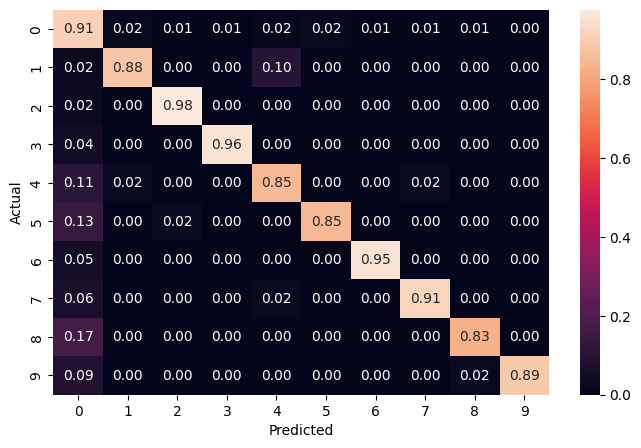

Model KTPM1 with lr = 0.001
F1 scores: 90%


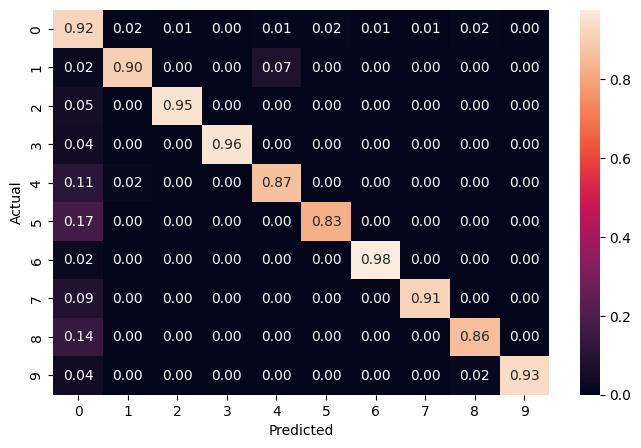

Model KTPM_expLR with lr = 0.01
F1 scores: 90%


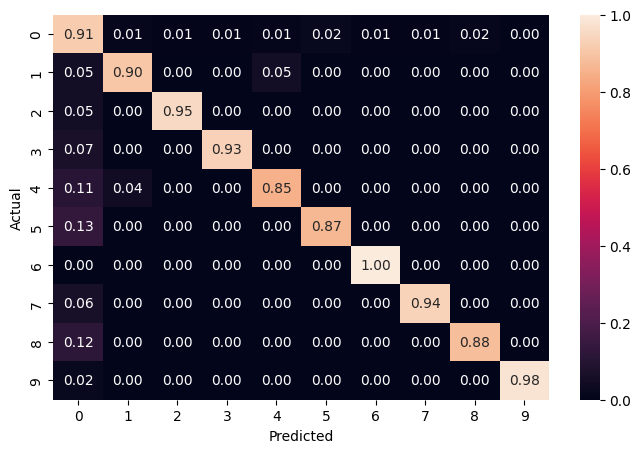

Model KTPM_expLR1 with lr = 0.015
F1 scores: 88%


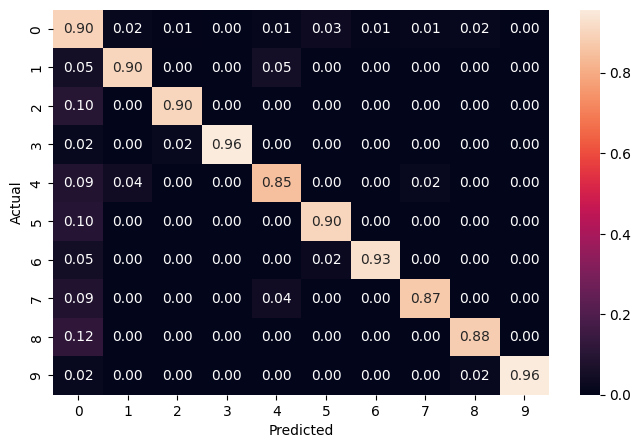

In [175]:
for m in KTPM_models.keys():
    print(f"Model {m} with lr = {KTPM_lrs[m]}")


    y_pred = KTPM_models[m](X_test)

    f1 = MulticlassF1Score(num_classes= 10)
    print(f"F1 scores: {f1(y_pred, y_test).item() * 100:.0f}%")

    _, predicted = torch.max(y_pred, 1)
    predicted = predicted.numpy()
    actual = y_test.numpy()

    cm = metrics.confusion_matrix(actual,  predicted)

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    plt.show()


## Test 20th July data

In [117]:
df_20jul = pd.read_csv('20Jul.csv', sep = ';')

# Read data
df_20jul = df_20jul.drop(columns = ['time', 'Predicted AP']).copy()

for c in df_20jul.columns[:-1]:
    df_20jul[c] = df_20jul[c] / TP_df[c].abs().max()
    

y_20jul = df_20jul['AP']
X_20jul = df_20jul.drop(columns = ['AP'])

encoder = LabelEncoder()
encoder.fit(y_29jul)
y_20jul = encoder.transform(y_29jul)

# Convert to 2D PyTorch tensors
X_20jul = torch.tensor(X_20jul.values, dtype=torch.float32)
y_20jul = torch.tensor(y_20jul, dtype=torch.long)


Model KTPM with lr = 0.0001
F1 score: 77%


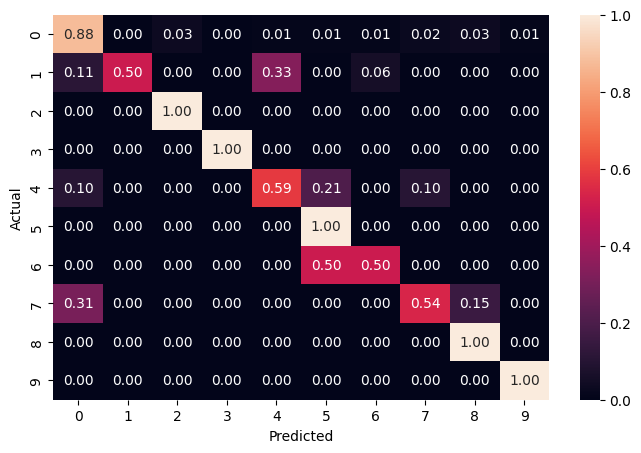

Model KTPM1 with lr = 0.001
F1 score: 81%


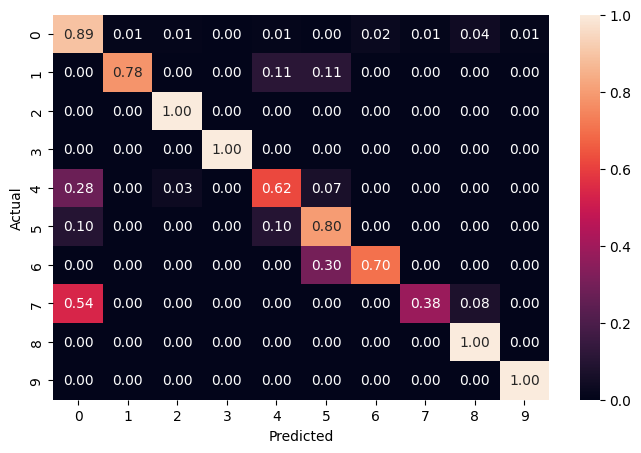

Model KTPM_expLR with lr = 0.01
F1 score: 74%


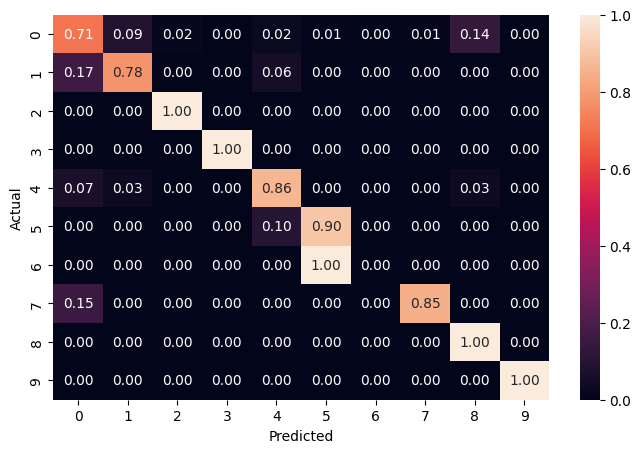

Model KTPM_expLR1 with lr = 0.015
F1 score: 69%


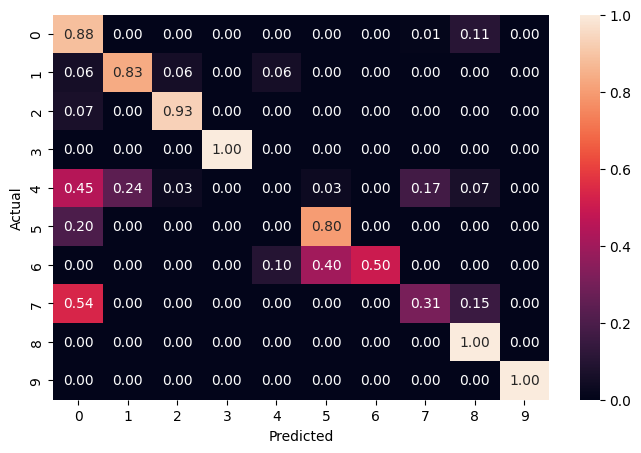

In [176]:
for m in KTPM_models.keys():
    print(f"Model {m} with lr = {KTPM_lrs[m]}")
    y_pred = KTPM_models[m](X_20jul)

    f1 = MulticlassF1Score(num_classes= 10)
    print(f"F1 score: {f1(y_pred, y_20jul).item() * 100:.0f}%")

    _, predicted = torch.max(y_pred, 1)
    predicted = predicted.numpy()
    actual = y_20jul.numpy()

    cm = metrics.confusion_matrix(actual,  predicted)

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    plt.show()

With lr = 1e-4
F1 scores: 77%


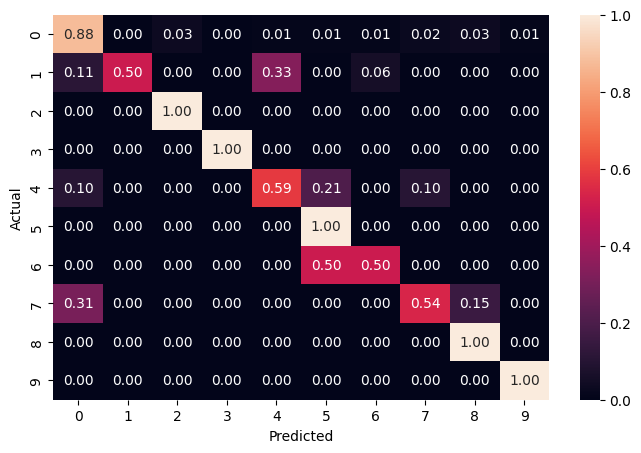

With lr = 1e-3
F1 scores: 81%


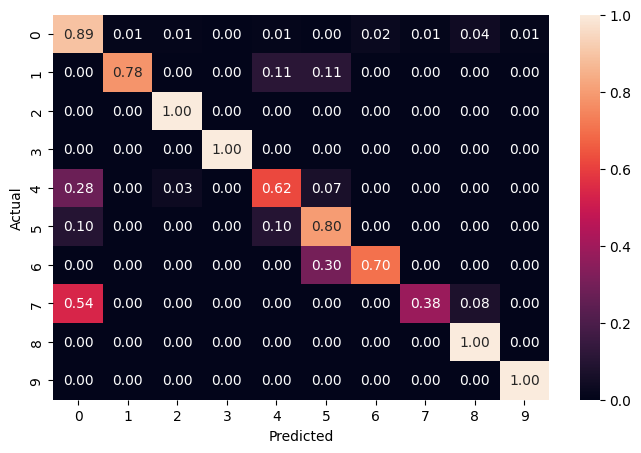

With lr = 1e-3
F1 scores: 74%


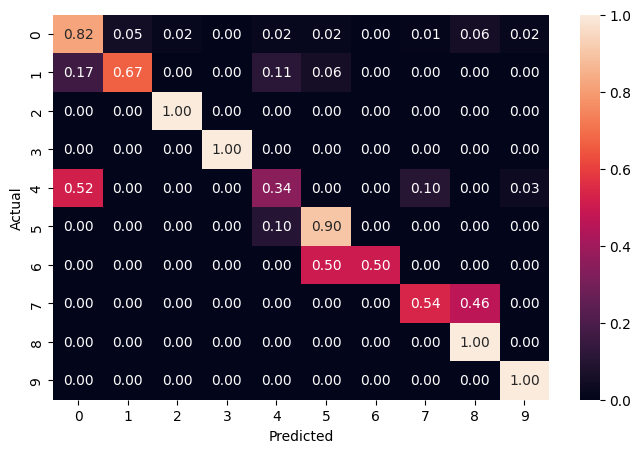

In [136]:
print("With lr = 1e-4")
y_pred = KTPM(X_20jul)

f1 = MulticlassF1Score(num_classes= 10)
print(f"F1 scores: {f1(y_pred, y_20jul).item() * 100:.0f}%")

_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_20jul.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.show()


print("With lr = 1e-3")
y_pred = KTPM1(X_20jul)

f1 = MulticlassF1Score(num_classes= 10)
print(f"F1 scores: {f1(y_pred, y_20jul).item() * 100:.0f}%")

_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_20jul.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.show()


print("With lr = 1e-3")
y_pred = KTPM2(X_20jul)

f1 = MulticlassF1Score(num_classes= 10)
print(f"F1 scores: {f1(y_pred, y_20jul).item() * 100:.0f}%")

_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_20jul.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.show()

# Train only on TP data

In [29]:
normed_TP_df
y_TP = normed_TP_df['AP']
X_TP = normed_TP_df.drop(columns = ['AP'])

encoder = LabelEncoder()
encoder.fit(y_TP)
y_TP = encoder.transform(y_TP)

# Convert to 2D PyTorch tensors
X_TP = torch.tensor(X_TP.values, dtype=torch.float32)
y_TP = torch.tensor(y_TP, dtype=torch.long)

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X_TP, y_TP, train_size=0.8, shuffle=True)

In [75]:
class_counts = torch.bincount(y_TP)
total_count = class_counts.sum()

class_weights = total_count / (len(class_counts) * class_counts)
class_weights

tensor([0.1895, 2.0819, 1.9636, 1.8783, 1.8783, 1.8783, 2.0093, 1.9200, 1.9416,
        1.6615])

In [31]:
TPSM = Deep()

acc = model_train(TPSM, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights) # lr = 1e-4
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 2.285291910171509; Loss: 2.2099251747131348
Epoch 100/1000; F1 Score: 81.8963623046875; Loss: 0.4837168753147125
Epoch 200/1000; F1 Score: 83.22198486328125; Loss: 0.4845345616340637
Epoch 300/1000; F1 Score: 82.3833999633789; Loss: 0.5044153332710266
Epoch 400/1000; F1 Score: 82.14723205566406; Loss: 0.43259623646736145
Epoch 500/1000; F1 Score: 82.20426940917969; Loss: 0.402251273393631
Epoch 600/1000; F1 Score: 83.89508819580078; Loss: 0.3456169664859772
Epoch 700/1000; F1 Score: 83.20145416259766; Loss: 0.2564190924167633
Epoch 800/1000; F1 Score: 83.46666717529297; Loss: 0.11375744640827179
Epoch 900/1000; F1 Score: 82.84669494628906; Loss: 0.03792252764105797
Achieved F1 Score: 84.90%


In [76]:
TPSM1 = Deep()

acc = model_train(TPSM1, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1e-2)
print(f"Achieved F1 Score: {acc:.2f}%")
torch.save(TPSM1, f'{round(acc)}_TPSM1.pth')

Epoch 0/1000; F1 Score: 28.707181930541992; Loss: 1.7538284063339233
Epoch 100/1000; F1 Score: 83.11117553710938; Loss: 0.19367347657680511
Epoch 200/1000; F1 Score: 77.8338851928711; Loss: 0.4043174982070923
Epoch 300/1000; F1 Score: 80.25641632080078; Loss: 0.2728034257888794
Epoch 400/1000; F1 Score: 78.58619689941406; Loss: 0.2496800720691681
Epoch 500/1000; F1 Score: 77.56790161132812; Loss: 0.49846822023391724
Epoch 600/1000; F1 Score: 80.8683853149414; Loss: 0.4134250581264496
Epoch 700/1000; F1 Score: 73.65213012695312; Loss: 0.7430483102798462
Epoch 800/1000; F1 Score: 81.18194580078125; Loss: 0.30108073353767395
Epoch 900/1000; F1 Score: 84.013427734375; Loss: 0.31206899881362915
Achieved F1 Score: 87.61%


In [73]:
TPSM2 = Deep()

acc = model_train(TPSM2, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1.5e-3)
print(f"Achieved F1 Score: {acc:.2f}%")
torch.save(TPSM2, f'{round(acc)}_TPSM2.pth')

Epoch 0/1000; F1 Score: 41.978214263916016; Loss: 1.5614277124404907
Epoch 100/1000; F1 Score: 83.72419738769531; Loss: 0.5184716582298279
Epoch 200/1000; F1 Score: 85.26234436035156; Loss: 1.131824016571045
Epoch 300/1000; F1 Score: 77.4793701171875; Loss: 0.44623851776123047
Epoch 400/1000; F1 Score: 86.99784851074219; Loss: 0.0016570617444813251
Epoch 500/1000; F1 Score: 81.4227066040039; Loss: 0.009112732484936714
Epoch 600/1000; F1 Score: 86.54090118408203; Loss: 0.0007376591674983501
Epoch 700/1000; F1 Score: 88.70429992675781; Loss: 8.284977411676664e-06
Epoch 800/1000; F1 Score: 85.99756622314453; Loss: 5.739597690990195e-05
Epoch 900/1000; F1 Score: 83.17230987548828; Loss: 8.46910261316225e-05
Achieved F1 Score: 89.57%


### Using Exp LR

In [39]:
TPSM_expLR = Deep()

acc = model_train(TPSM_expLR, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1e-2, lr_step = True)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 32.282493591308594; Loss: 1.7143676280975342
Epoch 100/1000; F1 Score: 81.48890686035156; Loss: 0.5519479513168335
Epoch 200/1000; F1 Score: 84.715576171875; Loss: 0.0009509829105809331
Epoch 300/1000; F1 Score: 84.3302993774414; Loss: 2.9802313861182483e-07
Epoch 400/1000; F1 Score: 85.27816772460938; Loss: 0.0
Epoch 500/1000; F1 Score: 84.71540832519531; Loss: 0.0
Epoch 600/1000; F1 Score: 85.06483459472656; Loss: 0.0
Epoch 700/1000; F1 Score: 84.88966369628906; Loss: 0.0
Epoch 800/1000; F1 Score: 84.88966369628906; Loss: 0.0
Epoch 900/1000; F1 Score: 84.88966369628906; Loss: 0.0
Achieved F1 Score: 86.90%


In [44]:
TPSM_expLR1 = Deep()

acc = model_train(TPSM_expLR1, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1.5e-2, lr_step = True)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 20.905309677124023; Loss: 1.2443064451217651
Epoch 100/1000; F1 Score: 84.01126861572266; Loss: 0.13409458100795746
Epoch 200/1000; F1 Score: 82.97521209716797; Loss: 0.05989479646086693
Epoch 300/1000; F1 Score: 79.96351623535156; Loss: 0.005077671259641647
Epoch 400/1000; F1 Score: 80.5121078491211; Loss: 0.0027107910718768835
Epoch 500/1000; F1 Score: 80.61158752441406; Loss: 0.0011175458785146475
Epoch 600/1000; F1 Score: 80.13614654541016; Loss: 0.000610159884672612
Epoch 700/1000; F1 Score: 79.95723724365234; Loss: 0.0005378224304877222
Epoch 800/1000; F1 Score: 79.95723724365234; Loss: 0.0004956060438416898
Epoch 900/1000; F1 Score: 79.95723724365234; Loss: 0.00047988566802814603
Achieved F1 Score: 85.27%


## Test 20th July Data

F1 scores: 75%


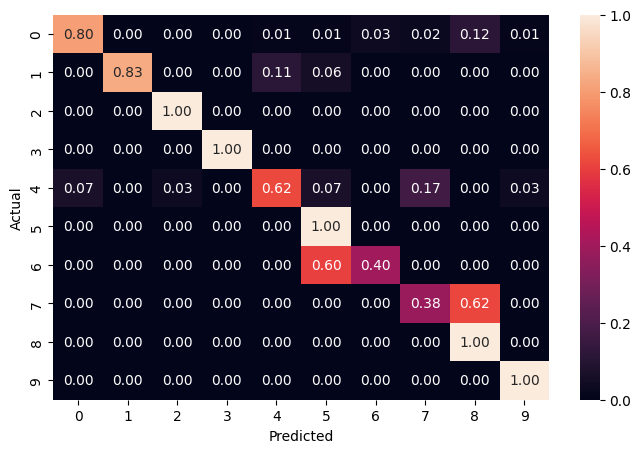

In [33]:
y_pred = TPSM(X_29jul)

f1 = MulticlassF1Score(num_classes= 10)
print(f"F1 scores: {f1(y_pred, y_29jul).item() * 100:.0f}%")

_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_29jul.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.show()

F1 scores: 76%


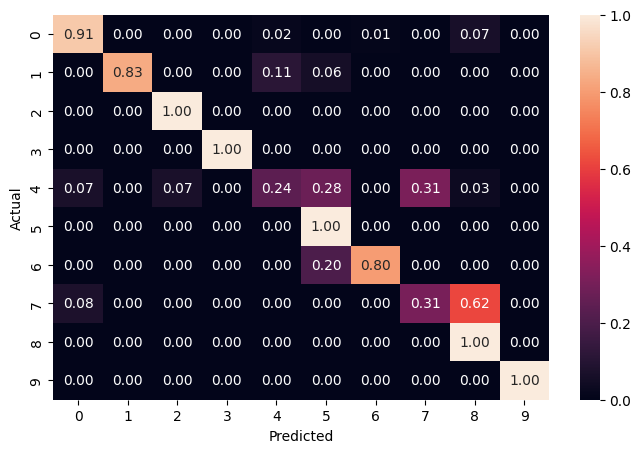

In [48]:
y_pred = TPSM_expLR(X_29jul)

f1 = MulticlassF1Score(num_classes= 10)
print(f"F1 scores: {f1(y_pred, y_29jul).item() * 100:.0f}%")

_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_29jul.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.show()

F1 scores: 86%


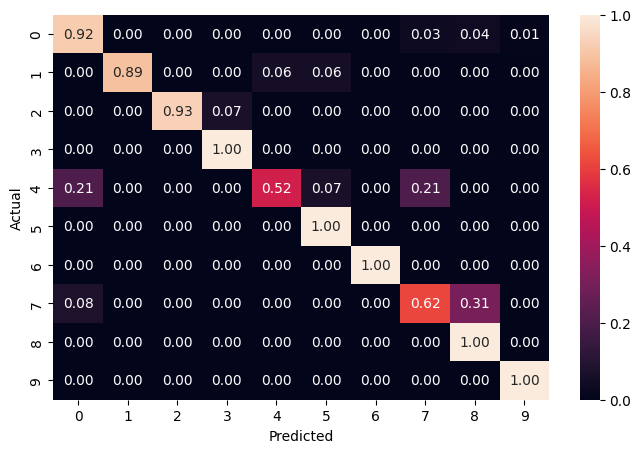

In [49]:
y_pred = TPSM_expLR1(X_29jul)

f1 = MulticlassF1Score(num_classes= 10)
print(f"F1 scores: {f1(y_pred, y_29jul).item() * 100:.0f}%")

_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_29jul.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.show()

In [56]:
torch.save(TPSM_expLR, '87F1_TPSM_expLR.pth')
torch.save(TPSM_expLR1, '85F1_TPSM_expLR1.pth')
torch.save(TPSM, '85F1_TPSM.pth')

F1 scores: 87%


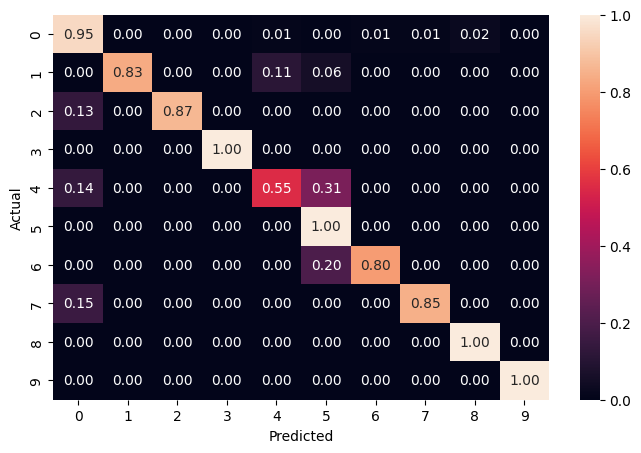

In [60]:
# NAO CORRER ESTE É DE UM MODELO Q NAO GUARDEI
y_pred = TPSM1(X_29jul)

f1 = MulticlassF1Score(num_classes= 10)
print(f"F1 scores: {f1(y_pred, y_29jul).item() * 100:.0f}%")

_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_29jul.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.show()

F1 scores: 84%


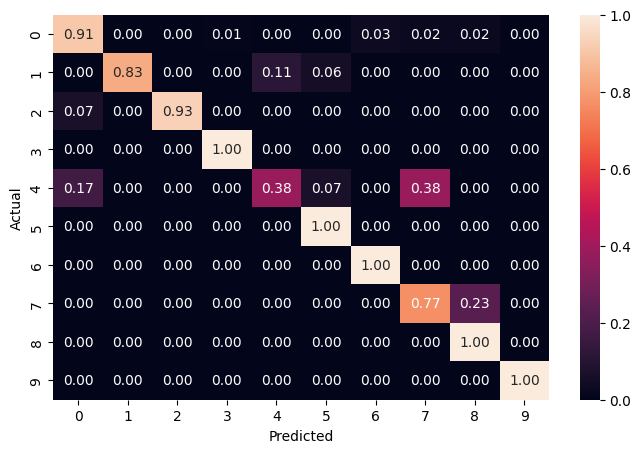

F1 scores: 79%


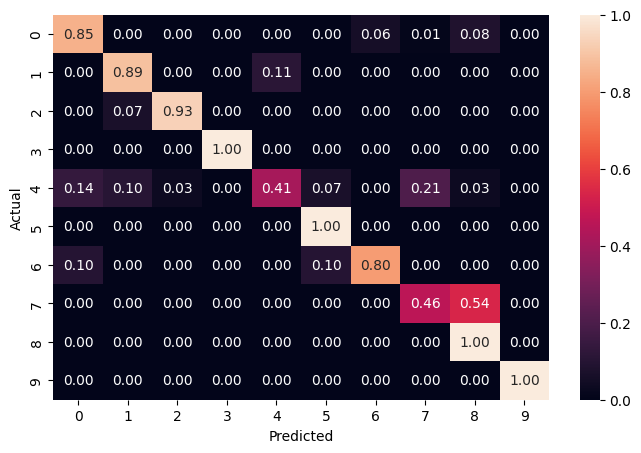

In [77]:
y_pred = TPSM1(X_29jul)

f1 = MulticlassF1Score(num_classes= 10)
print(f"F1 scores: {f1(y_pred, y_29jul).item() * 100:.0f}%")

_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_29jul.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.show()


y_pred = TPSM2(X_29jul)

f1 = MulticlassF1Score(num_classes= 10)
print(f"F1 scores: {f1(y_pred, y_29jul).item() * 100:.0f}%")

_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_29jul.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.show()